In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from data_loading import *
from isoform_pairwise_metrics import *

In [2]:
df = pd.read_csv('../../data/processed/190914_6K_affect_of_mapped_uniprot_dbds_with_flank_for_juan.tsv',
                 sep='\t')
dom_frac = df.groupby('isoacc')['num_match'].sum() / df.groupby('isoacc')['dom_len'].sum()
dom_frac = dom_frac.to_frame(name='dbd_fraction')
dom_frac['gene'] = dom_frac.index.map(df.drop_duplicates('isoacc').set_index('isoacc')['gene'])
df = dom_frac

In [3]:
isoforms = load_valid_isoform_clones()
y1h = load_y1h_pdi_data()
y1h = y1h.drop_duplicates()
n_pdi = (y1h.drop(columns='tf')
            .set_index('unique_acc')
            .sum(axis=1))
n_pdi.head()

unique_acc
CREB1|1/2|02E01    0
CREB1|2/2|01F12    3
DLX1|1/2|07A12     9
DLX1|2/2|07E09     0
DLX4|1/3|11A04     3
dtype: int64

In [4]:
# map each isoform to change in PDI vs reference
def delta_pdi(row):
    iso_acc = row.name
    ref_acc = df.loc[df['gene'] == row['gene'], :].index.min()
    if iso_acc == ref_acc:
        return np.nan
    n_ref = n_pdi.get(ref_acc, np.nan)
    n_iso = n_pdi.get(iso_acc, np.nan)
    if n_ref == 0:
        return np.nan
    return (n_iso - n_ref) / n_ref


df['delta_pdi'] = df.apply(delta_pdi, axis=1)
df = df.dropna(subset=['delta_pdi'])

In [5]:
df['delta_pdi'].values

array([-1.        ,  2.33333333, -1.        , -1.        , -1.        ,
       -1.        , -0.11764706, -0.66666667,  0.        ,  0.        ,
       -0.8       ,  0.        , -1.        , -1.        ,  2.        ,
       -1.        ,  0.4       ,  2.        ,  5.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        ,  0.5       ,  0.        ,  0.        , -1.        ,
       -1.        ,  3.5       ,  3.        , -1.        , -0.33333333,
       -0.66666667, -0.33333333, -0.11111111, -0.11111111,  0.05555556,
       -1.        ,  0.8       ,  0.8       ,  1.4       , -1.        ,
        1.        ])

In [6]:
df['dbd_pct_lost'] = (1. - df['dbd_fraction']) * 100.

/Users/lukelambourne/Work/tf_isoforms/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


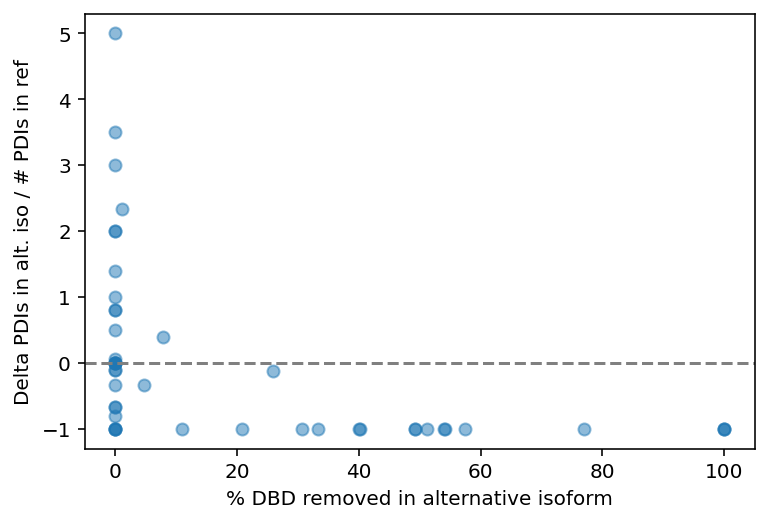

In [7]:
fig, ax = plt.subplots(1, 1)
ax.scatter(df['dbd_pct_lost'].values,
           df['delta_pdi'].values,
           alpha=0.5)
ax.axhline(0, linestyle='--', color='grey')
ax.set_ylabel('Delta PDIs in alt. iso / # PDIs in ref')
ax.set_xlabel('% DBD removed in alternative isoform')
plt.savefig('../../figures/DBD_change_vs_PDI_scatter.pdf', 
            bbox_inches='tight')

In [8]:
df.sort_values('delta_pdi', ascending=False)

,dbd_fraction,gene,delta_pdi,dbd_pct_lost
isoacc,,,,
LHX9|3/3|07A01,1.000000,LHX9,5.000000,0.000000
PKNOX1|3/4|06H03,1.000000,PKNOX1,3.500000,0.000000
PKNOX1|4/4|06G03,1.000000,PKNOX1,3.000000,0.000000
DLX4|2/3|10A03,0.988506,DLX4,2.333333,1.149425
HEY1|2/2|04E03,1.000000,HEY1,2.000000,0.000000
LHX9|2/3|06D10,1.000000,LHX9,2.000000,0.000000
TFAP2A|4/4|11C09,1.000000,TFAP2A,1.400000,0.000000
TGIF1|3/3|02B10,1.000000,TGIF1,1.000000,0.000000
TFAP2A|2/4|09G07,1.000000,TFAP2A,0.800000,0.000000


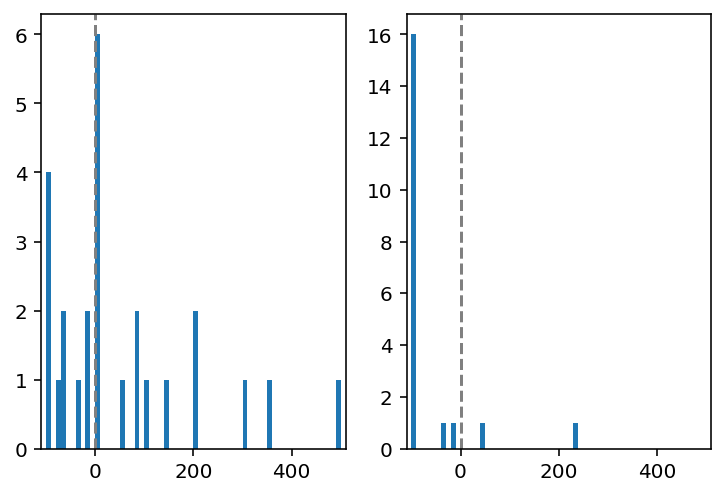

In [9]:
fig, axes = plt.subplots(1, 2)
axes[0].hist(df.loc[df['dbd_pct_lost'] == 0, 'delta_pdi'].values * 100,
             range=(-100, 500), bins=6*10)
axes[1].hist(df.loc[df['dbd_pct_lost'] > 0, 'delta_pdi'].values * 100,
             range=(-100, 500), bins=6*10)
for ax in axes:
    ax.axvline(0, linestyle='--', color='grey')
    ax.set_xlim(-110, 510)

In [10]:
import seaborn as sns

In [11]:
df['dbd_affected'] = df['dbd_pct_lost'] > 0
df['dbd_affected'] = df['dbd_affected'].map({False: 'Full DBD in\nalternative isoform', True: 'Partial or full\nloss of DBD'})

/Users/lukelambourne/Work/tf_isoforms/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/lukelambourne/Work/tf_isoforms/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


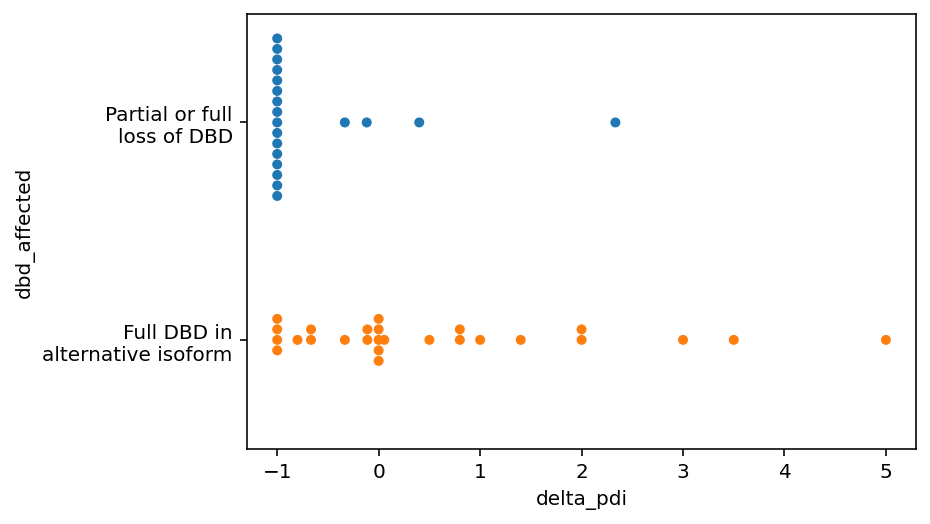

In [12]:

sns.swarmplot(data=df, x='delta_pdi', y='dbd_affected')

/Users/lukelambourne/Work/tf_isoforms/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


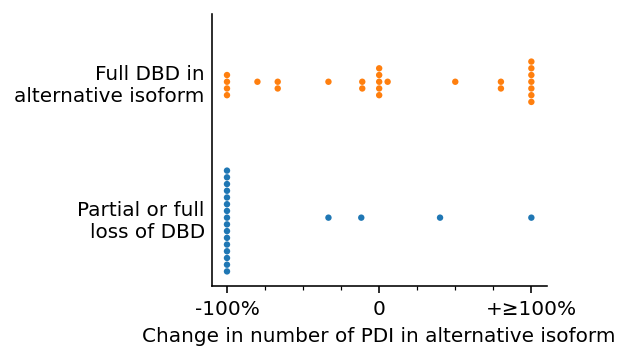

In [13]:
# make a version truncated at 100%

# TODO: labels, bigger points, smaller figure

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 2.5)
df['delta_pdi_trunc'] = df['delta_pdi'].clip(upper=1)
sns.swarmplot(data=df, 
              x='delta_pdi_trunc', 
              y='dbd_affected',
              size=3.2,
              ax=ax,
              alpha=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.yaxis.set_tick_params(length=0)
ax.set_ylabel('')
ax.set_xticks([-1, 0, 1])
ax.set_xticks(np.linspace(-1, 1, 9), minor=True)
ax.set_xticklabels(['-100%', '0', '+≥100%'])
ax.invert_yaxis()
ax.set_xlabel('Change in number of PDI in alternative isoform')
plt.savefig('../../figures/DBD_change_vs_PDI_truncated.pdf', bbox_inches='tight')

/Users/lukelambourne/Work/tf_isoforms/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


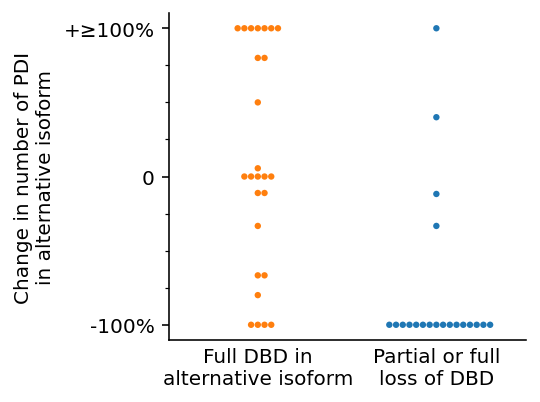

In [14]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3.2, 3)
df['delta_pdi_trunc'] = df['delta_pdi'].clip(upper=1)
sns.swarmplot(data=df, 
              y='delta_pdi_trunc', 
              x='dbd_affected',
              size=3.2,
              ax=ax,
              alpha=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_xlabel('')
ax.set_yticks([-1, 0, 1])
ax.set_yticks(np.linspace(-1, 1, 9), minor=True)
ax.set_yticklabels(['-100%', '0', '+≥100%'])
ax.invert_xaxis()
ax.set_ylabel('Change in number of PDI\nin alternative isoform')
plt.savefig('../../figures/DBD_change_vs_PDI_truncated_inverted.pdf', bbox_inches='tight')

In [15]:
(df['dbd_pct_lost'] > 0).sum()

20

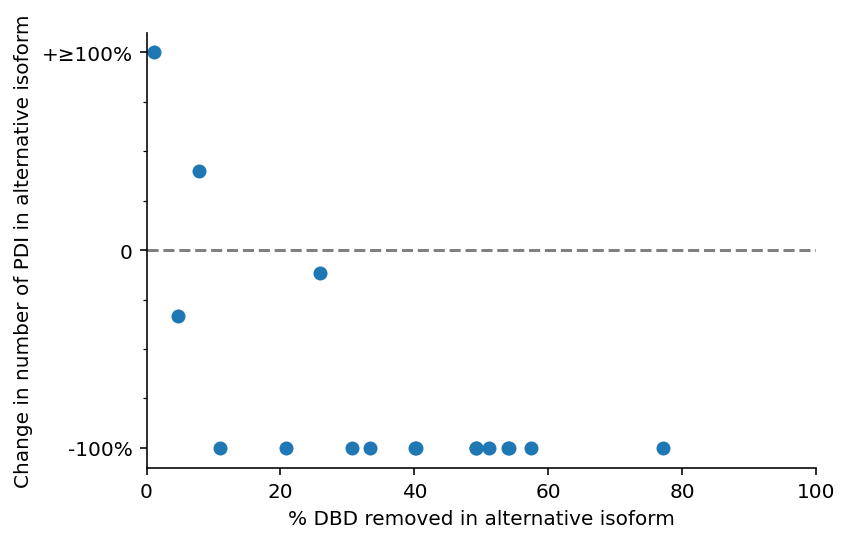

In [16]:
fig, ax = plt.subplots(1, 1)
ax.scatter(df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'dbd_pct_lost'].values,
           df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'delta_pdi_trunc'].values,
           alpha=1)
ax.axhline(0, linestyle='--', color='grey')

ax.set_xlabel('% DBD removed in alternative isoform')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0, 100)
ax.set_yticks([-1, 0, 1])
ax.set_yticks(np.linspace(-1, 1, 9), minor=True)
ax.set_yticklabels(['-100%', '0', '+≥100%'])
ax.set_ylabel('Change in number of PDI in alternative isoform')
plt.savefig('../../figures/DBD_change_vs_PDI_scatter_only_partially_affected.pdf', 
            bbox_inches='tight')

In [18]:
df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100) & (df['delta_pdi_trunc'] > -1), :]

,dbd_fraction,gene,delta_pdi,dbd_pct_lost,dbd_affected,delta_pdi_trunc
isoacc,,,,,,
DLX4|2/3|10A03,0.988506,DLX4,2.333333,1.149425,Partial or full\nloss of DBD,1.000000
EBF3|3/3|09E11,0.740642,EBF3,-0.117647,25.935829,Partial or full\nloss of DBD,-0.117647
LCOR|2/2|12B05,0.921053,LCOR,0.400000,7.894737,Partial or full\nloss of DBD,0.400000
TBX5|2/3|08C02,0.953052,TBX5,-0.333333,4.694836,Partial or full\nloss of DBD,-0.333333
